In [3]:
!nvidia-smi

import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

!pip install ultralytics -q

from ultralytics import YOLO
import ultralytics
ultralytics.checks()
print("✅ All installed!")

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.6/112.6 GB disk)
✅ All installed!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
BASE_DIR = '/content/drive/MyDrive/Yolo-Model-Face-Mask'

# Verify paths exist
for folder in ['train', 'valid', 'test']:
    path = os.path.join(BASE_DIR, folder)
    exists = "✅" if os.path.exists(path) else "❌"
    print(f"{exists} {path}")

classes_path = os.path.join(BASE_DIR, 'classes.txt')
print(f"{'✅' if os.path.exists(classes_path) else '❌'} {classes_path}")

Mounted at /content/drive
✅ /content/drive/MyDrive/Yolo-Model-Face-Mask/train
✅ /content/drive/MyDrive/Yolo-Model-Face-Mask/valid
✅ /content/drive/MyDrive/Yolo-Model-Face-Mask/test
✅ /content/drive/MyDrive/Yolo-Model-Face-Mask/classes.txt


In [5]:
import os, glob

BASE_DIR = '/content/drive/MyDrive/Yolo-Model-Face-Mask'

# Read class names
with open(os.path.join(BASE_DIR, 'classes.txt'), 'r') as f:
    class_names = [line.strip() for line in f.readlines() if line.strip()]

print(f"✅ Classes ({len(class_names)}): {class_names}")

# Count files per split
for split in ['train', 'valid', 'test']:
    split_path = os.path.join(BASE_DIR, split)
    if not os.path.exists(split_path):
        print(f"  ❌ {split} folder not found!")
        continue
    all_files = os.listdir(split_path)
    img_exts  = {'.jpg', '.jpeg', '.png', '.bmp'}
    imgs      = [f for f in all_files if os.path.splitext(f)[1].lower() in img_exts]
    labels    = [f for f in all_files if f.endswith('.txt')]

    # Also check subfolders
    if os.path.exists(os.path.join(split_path, 'images')):
        imgs   = glob.glob(f'{split_path}/images/*.*')
        labels = glob.glob(f'{split_path}/labels/*.txt')

    print(f"  {split}: {len(imgs)} images | {len(labels)} labels")

✅ Classes (2): ['no_mask', 'mask']
  train: 700 images | 700 labels
  valid: 100 images | 100 labels
  test: 120 images | 120 labels


In [6]:
# Copying from Drive to local /content speeds up training significantly
import shutil, os, glob
from tqdm.notebook import tqdm

BASE_DIR   = '/content/drive/MyDrive/Yolo-Model-Face-Mask'
LOCAL_DIR  = '/content/dataset'
img_exts   = {'.jpg', '.jpeg', '.png', '.bmp'}

os.makedirs(LOCAL_DIR, exist_ok=True)

for split in ['train', 'valid', 'test']:
    drive_split = os.path.join(BASE_DIR, split)
    local_img   = f'{LOCAL_DIR}/{split}/images'
    local_lbl   = f'{LOCAL_DIR}/{split}/labels'
    os.makedirs(local_img, exist_ok=True)
    os.makedirs(local_lbl, exist_ok=True)

    # Detect structure: flat OR images/labels subfolders
    sub_img = os.path.join(drive_split, 'images')
    sub_lbl = os.path.join(drive_split, 'labels')

    if os.path.exists(sub_img):
        src_imgs   = glob.glob(f'{sub_img}/*.*')
        src_labels = glob.glob(f'{sub_lbl}/*.txt')
    else:
        all_files  = os.listdir(drive_split)
        src_imgs   = [os.path.join(drive_split, f) for f in all_files
                      if os.path.splitext(f)[1].lower() in img_exts]
        src_labels = [os.path.join(drive_split, f) for f in all_files
                      if f.endswith('.txt')]

    print(f"Copying {split}: {len(src_imgs)} images, {len(src_labels)} labels...")

    for f in tqdm(src_imgs,   desc=f'{split} images'):
        shutil.copy(f, local_img)
    for f in tqdm(src_labels, desc=f'{split} labels'):
        shutil.copy(f, local_lbl)

print("\n✅ Dataset copied to /content/dataset!")

# Verify
for split in ['train', 'valid', 'test']:
    imgs = glob.glob(f'{LOCAL_DIR}/{split}/images/*.*')
    lbls = glob.glob(f'{LOCAL_DIR}/{split}/labels/*.txt')
    print(f"  {split}: {len(imgs)} images | {len(lbls)} labels")

Copying train: 700 images, 700 labels...


train images:   0%|          | 0/700 [00:00<?, ?it/s]

train labels:   0%|          | 0/700 [00:00<?, ?it/s]

Copying valid: 100 images, 100 labels...


valid images:   0%|          | 0/100 [00:00<?, ?it/s]

valid labels:   0%|          | 0/100 [00:00<?, ?it/s]

Copying test: 120 images, 120 labels...


test images:   0%|          | 0/120 [00:00<?, ?it/s]

test labels:   0%|          | 0/120 [00:00<?, ?it/s]


✅ Dataset copied to /content/dataset!
  train: 700 images | 700 labels
  valid: 100 images | 100 labels
  test: 120 images | 120 labels


In [7]:
import yaml

LOCAL_DIR   = '/content/dataset'
yaml_path   = '/content/face_mask_data.yaml'

data_yaml = {
    'path' : LOCAL_DIR,
    'train': 'train/images',
    'val'  : 'valid/images',
    'test' : 'test/images',
    'nc'   : len(class_names),
    'names': class_names
}

with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print("✅ YAML created:")
print(open(yaml_path).read())

✅ YAML created:
names:
- no_mask
- mask
nc: 2
path: /content/dataset
test: test/images
train: train/images
val: valid/images



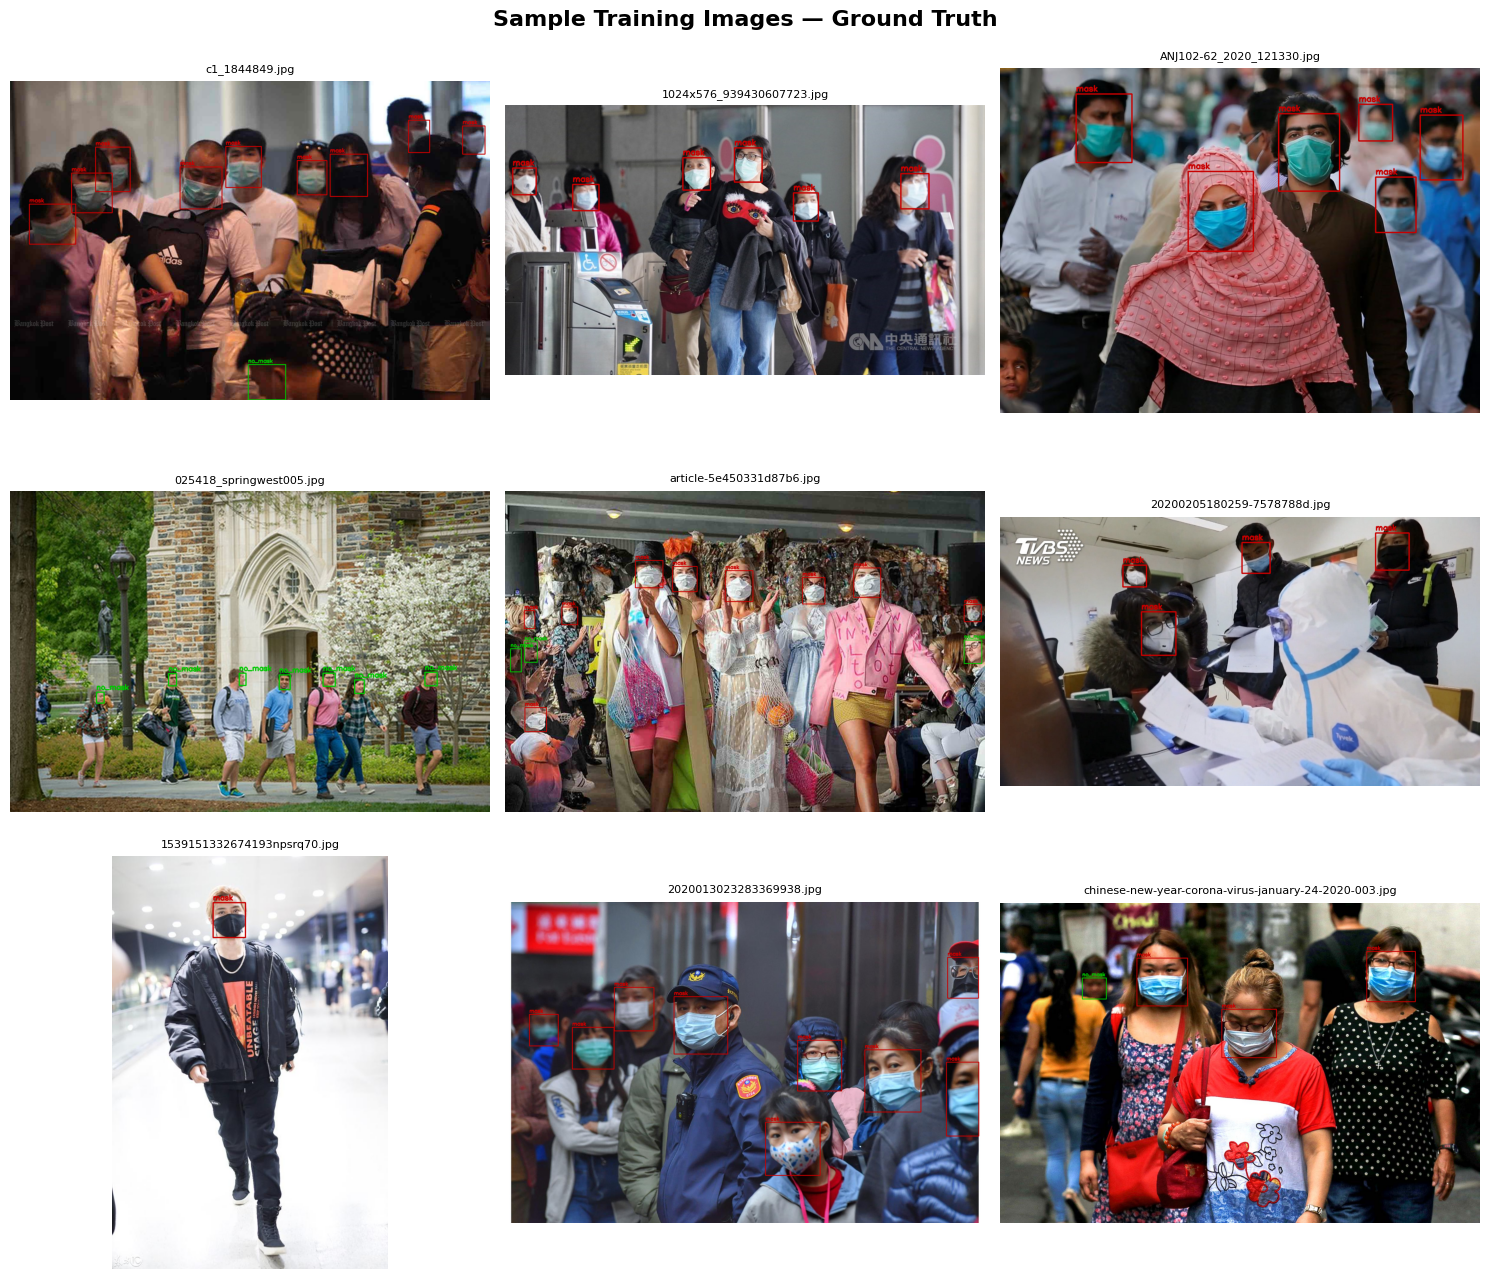

✅ Sample images shown!


In [8]:
import cv2
import matplotlib.pyplot as plt
import random

LOCAL_DIR  = '/content/dataset'
COLOR_MAP  = [(0,200,0), (200,0,0), (200,130,0), (0,130,200), (130,0,200)]

def draw_boxes(img_path, label_path, names):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                p = line.strip().split()
                if len(p) == 5:
                    cls = int(p[0])
                    cx, cy, bw, bh = float(p[1]), float(p[2]), float(p[3]), float(p[4])
                    x1 = int((cx - bw/2) * w)
                    y1 = int((cy - bh/2) * h)
                    x2 = int((cx + bw/2) * w)
                    y2 = int((cy + bh/2) * h)
                    color = COLOR_MAP[cls % len(COLOR_MAP)]
                    cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
                    label = names[cls] if cls < len(names) else str(cls)
                    cv2.putText(img, label, (x1, y1-6),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)
    return img

all_train_imgs = glob.glob(f'{LOCAL_DIR}/train/images/*.*')
samples        = random.sample(all_train_imgs, min(9, len(all_train_imgs)))

fig, axes = plt.subplots(3, 3, figsize=(15, 13))
fig.suptitle('Sample Training Images — Ground Truth', fontsize=16, fontweight='bold')

for ax, img_path in zip(axes.flatten(), samples):
    fname      = os.path.splitext(os.path.basename(img_path))[0] + '.txt'
    label_path = f'{LOCAL_DIR}/train/labels/{fname}'
    img        = draw_boxes(img_path, label_path, class_names)
    if img is not None:
        ax.imshow(img)
    ax.axis('off')
    ax.set_title(os.path.basename(img_path), fontsize=8)

plt.tight_layout()
plt.show()
print("✅ Sample images shown!")

In [9]:
from ultralytics import YOLO
import torch

model = YOLO('yolov8s.pt')   # nano=yolov8n, small=yolov8s, medium=yolov8m

print("🚀 Training started...")

results = model.train(
    data      = yaml_path,
    epochs    = 50,
    imgsz     = 640,
    batch     = 16,           # reduce to 8 if OOM error
    name      = 'face_mask',
    project   = '/content/runs',
    patience  = 15,
    lr0       = 0.01,
    lrf       = 0.001,
    optimizer = 'AdamW',
    fliplr    = 0.5,
    mosaic    = 1.0,
    flipud    = 0.0,
    hsv_h     = 0.015,
    hsv_s     = 0.7,
    hsv_v     = 0.4,
    verbose   = True,
    device    = 0 if torch.cuda.is_available() else 'cpu'
)

print("✅ Training complete!")

🚀 Training started...
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/face_mask_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.001, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=face_mask, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, pa

Best weights: /content/runs/face_mask/weights/best.pt

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1117.0±1202.9 MB/s, size: 80.3 KB)
val: Scanning /content/dataset/valid/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 32.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.3it/s 5.6s
                   all        100        327      0.863      0.807      0.853      0.514
               no_mask         27         49      0.857      0.714      0.774      0.408
                  mask         93        278      0.869      0.899      0.932      0.619
Speed: 6.0ms preprocess, 24.4ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to /content/runs/detect/val
📊 Validation Metrics:
  mAP50     : 0.8532
  mA

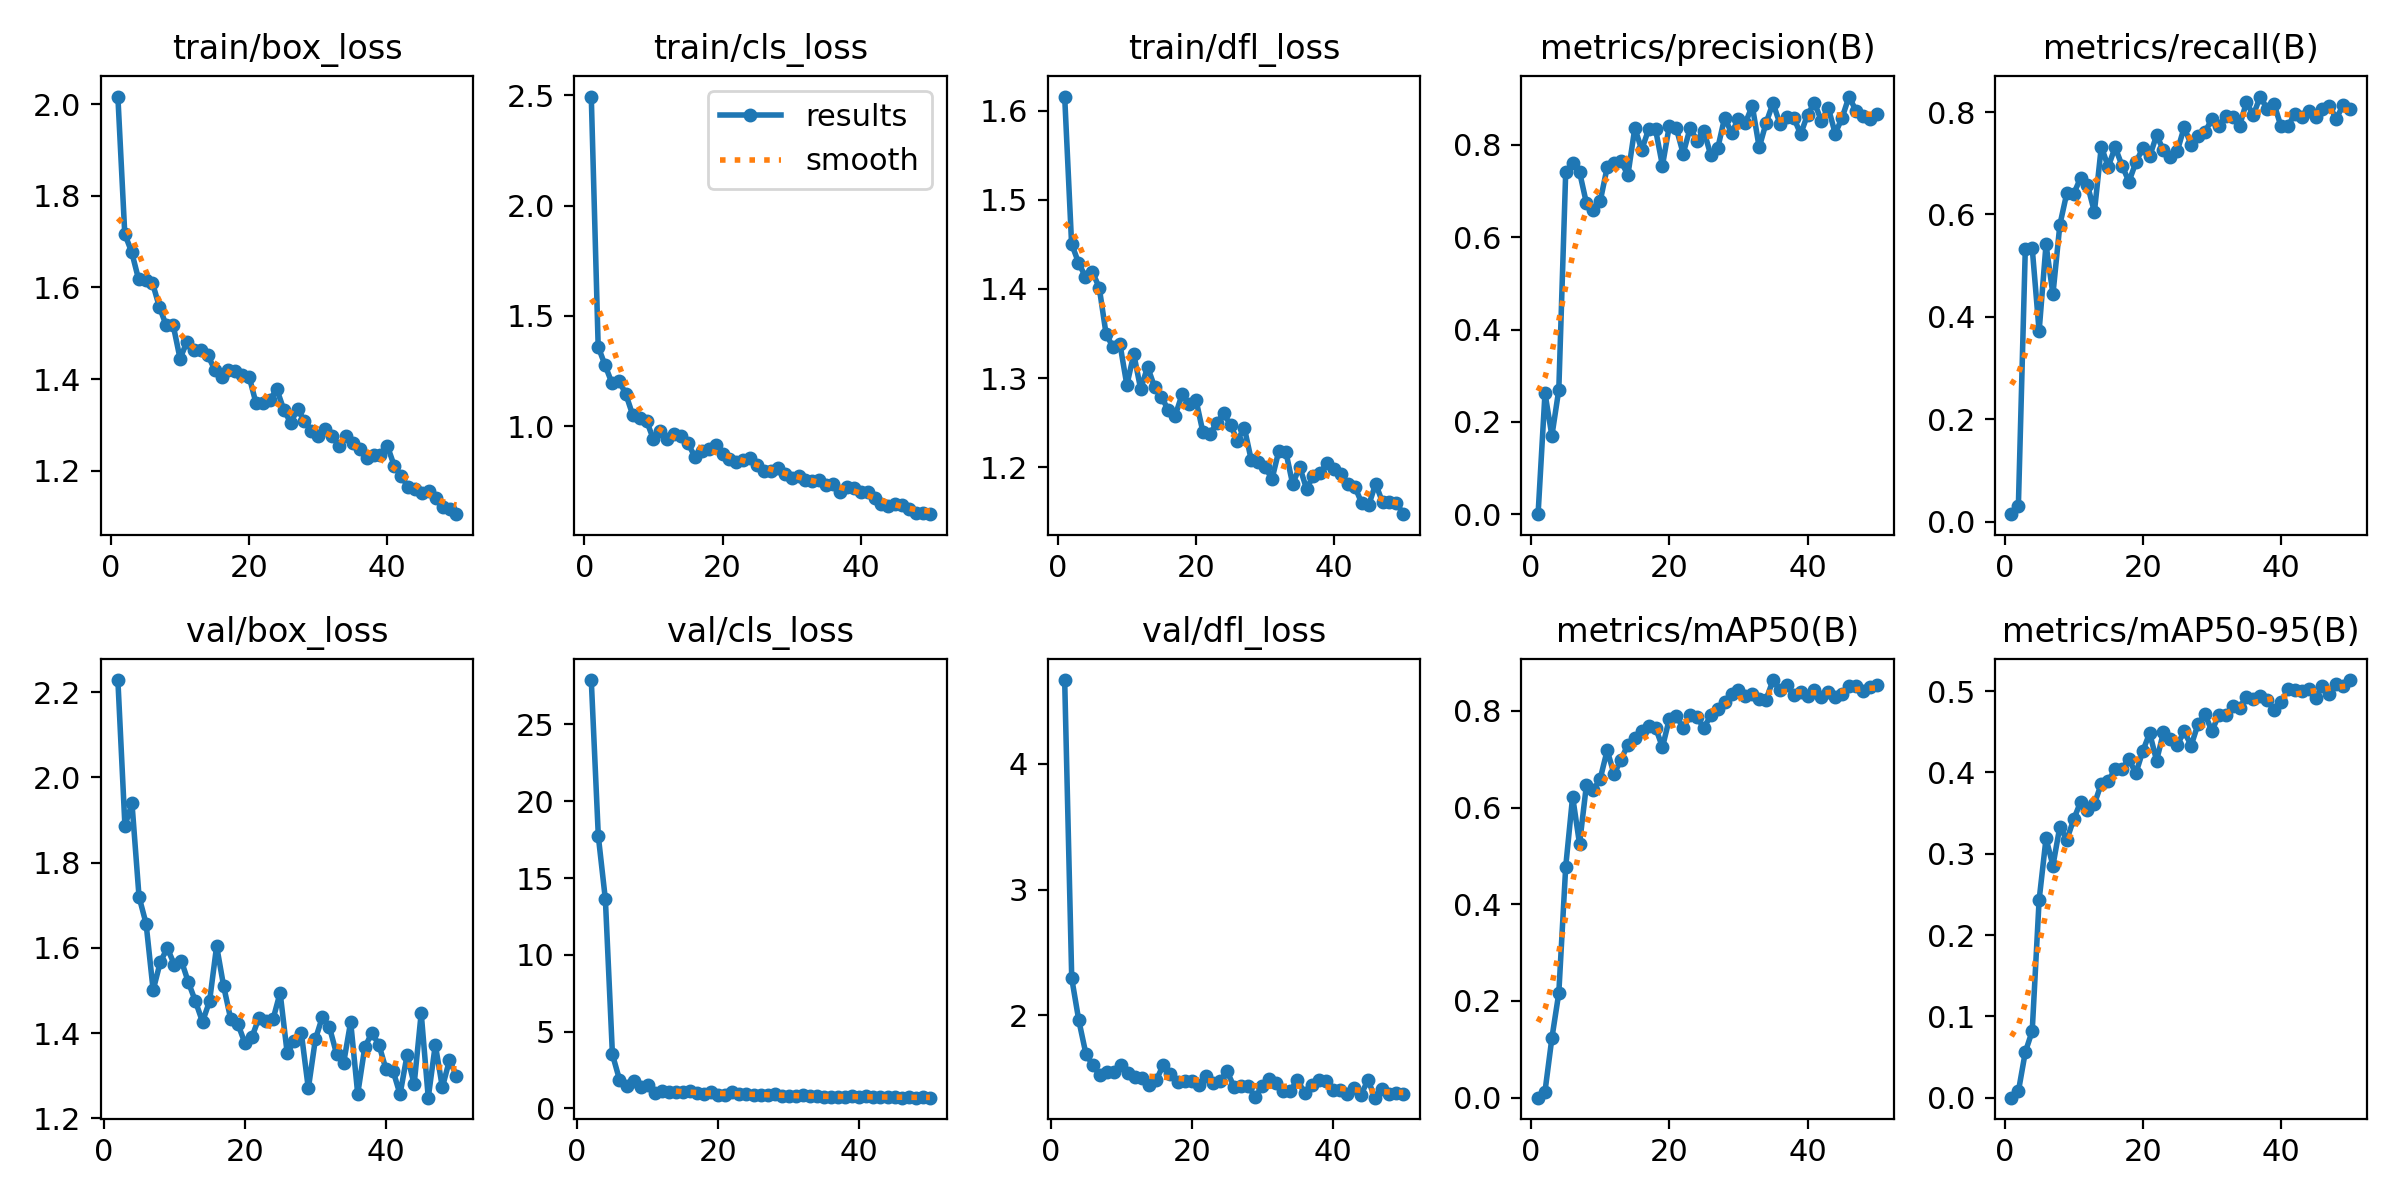


🔢 Confusion Matrix:


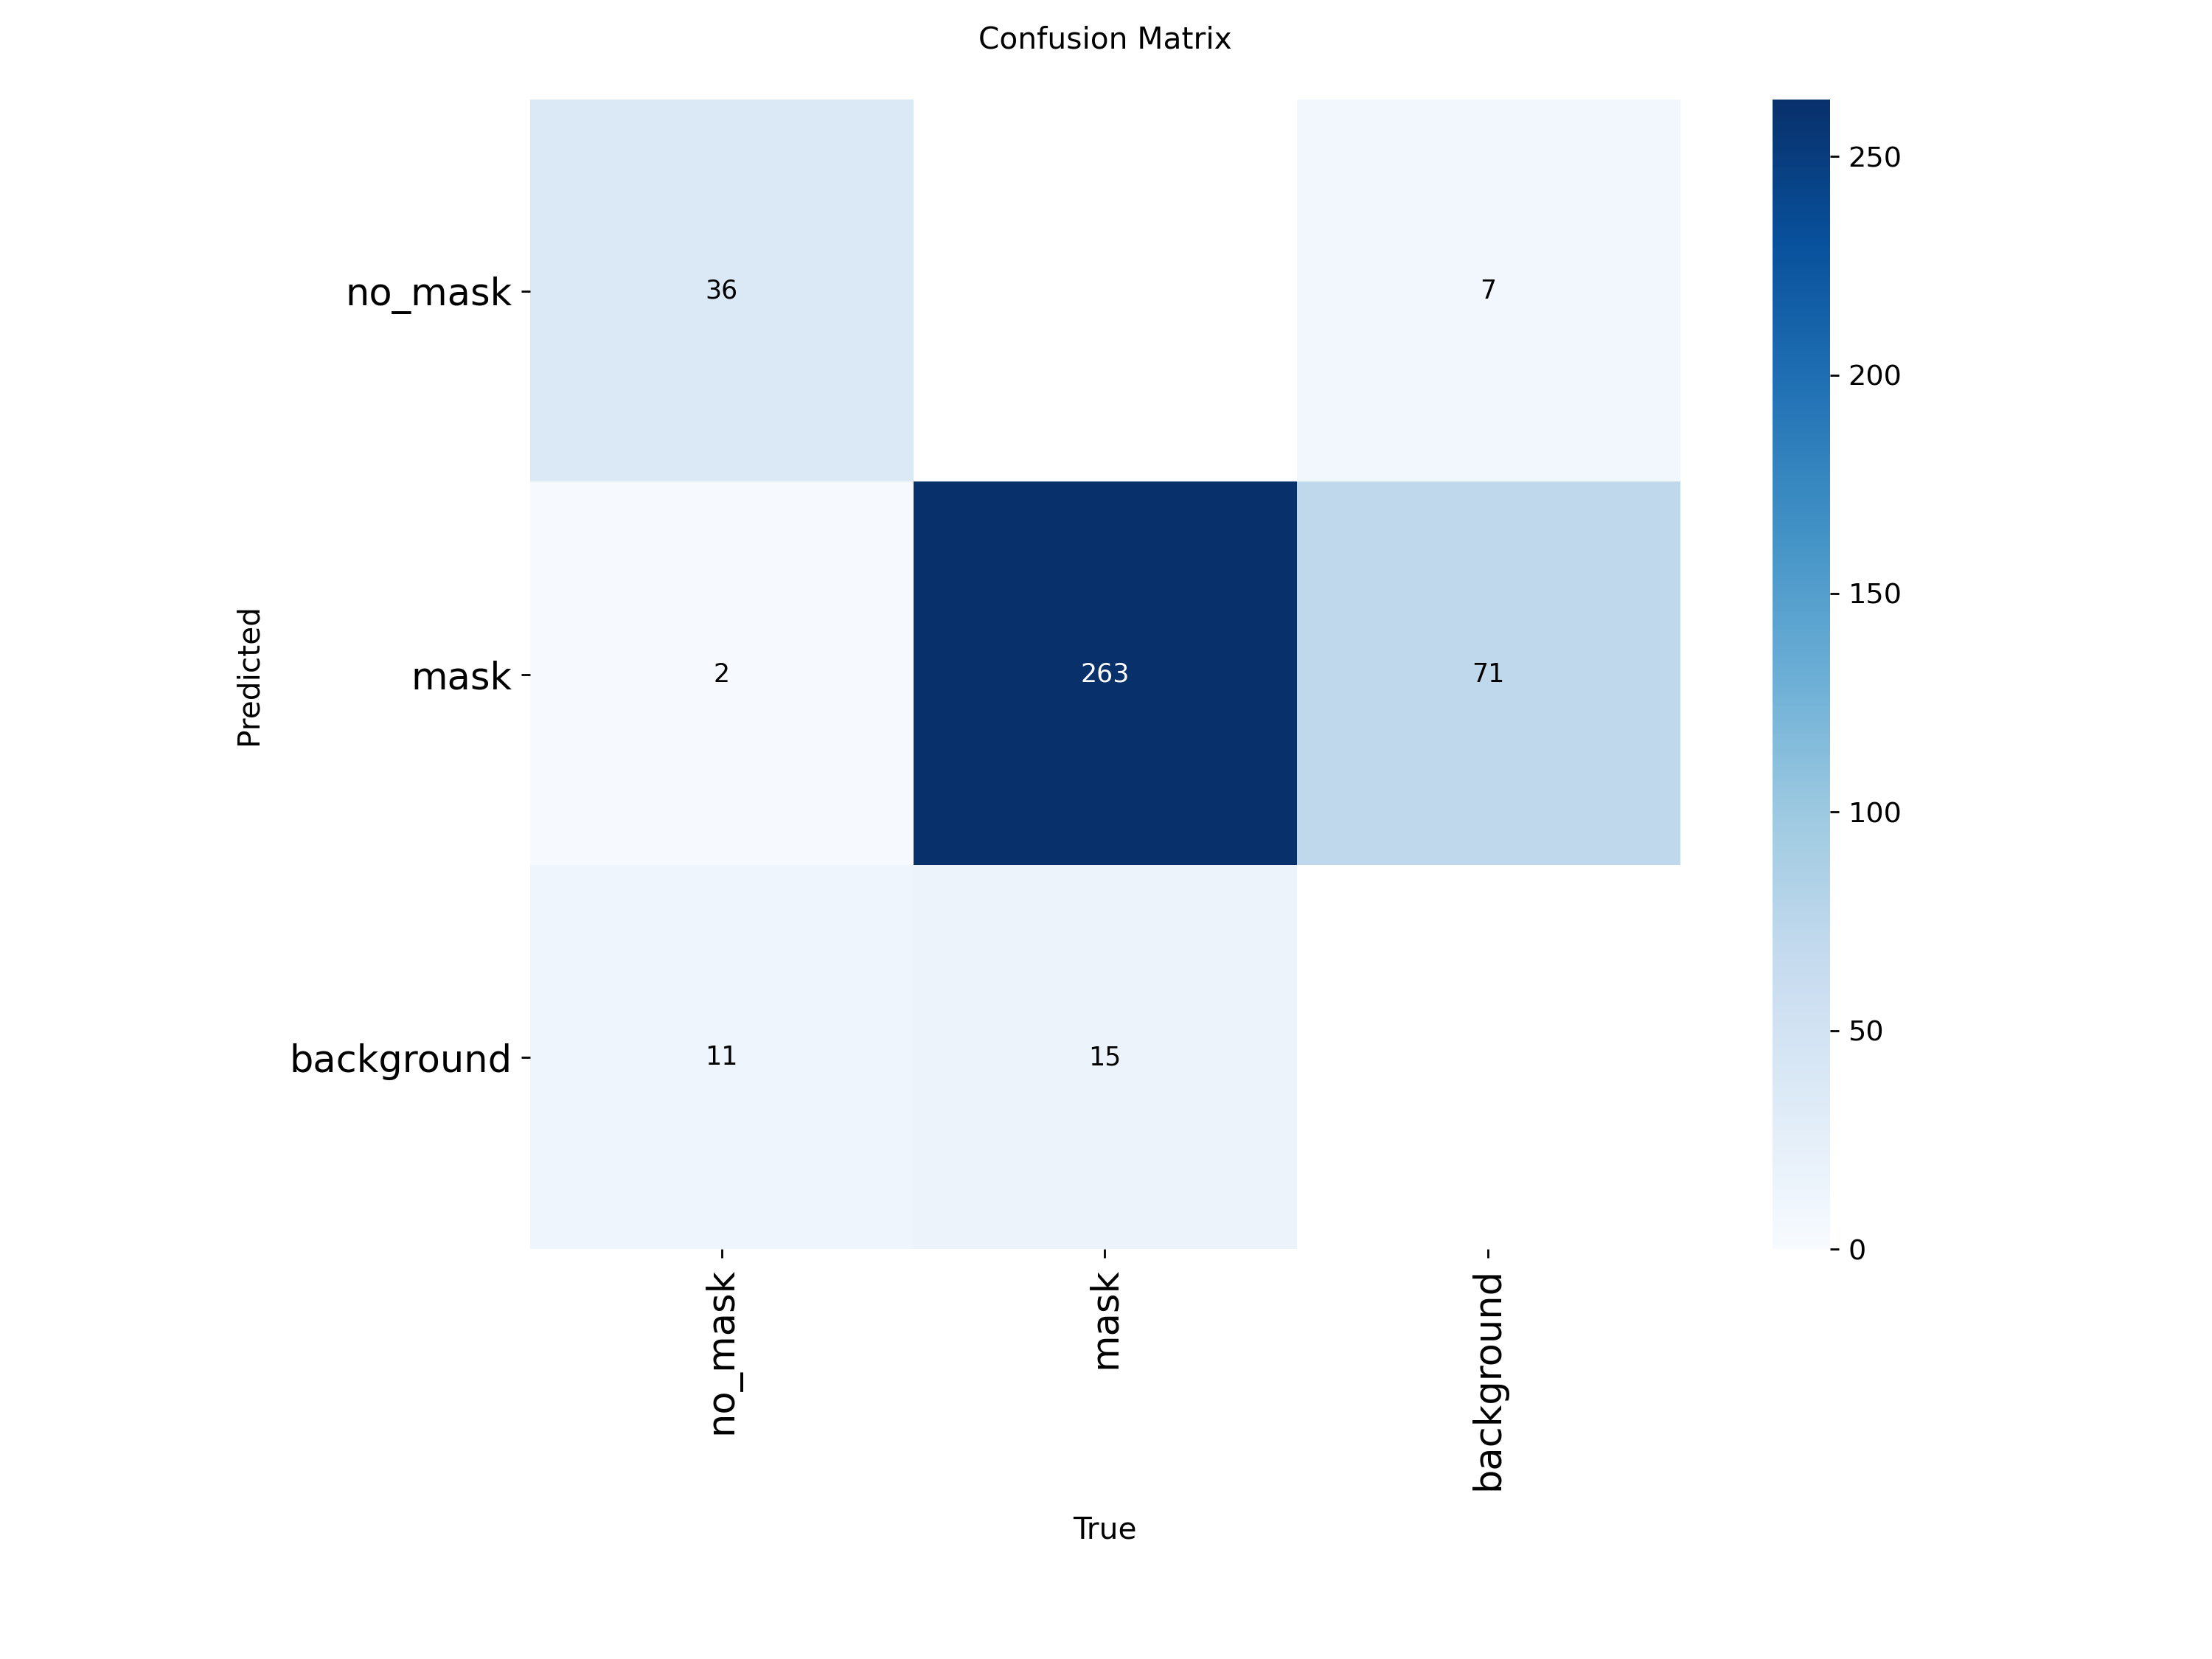

In [10]:
from IPython.display import Image, display

run_dirs     = sorted(glob.glob('/content/runs/face_mask*'))
run_dir      = run_dirs[-1]
best_weights = os.path.join(run_dir, 'weights', 'best.pt')

print(f"Best weights: {best_weights}\n")

# Metrics
metrics = model.val(data=yaml_path, split='val')
print("📊 Validation Metrics:")
print(f"  mAP50     : {metrics.box.map50:.4f}")
print(f"  mAP50-95  : {metrics.box.map:.4f}")
print(f"  Precision : {metrics.box.mp:.4f}")
print(f"  Recall    : {metrics.box.mr:.4f}")
print("\n  Per-class AP50:")
for i, ap in enumerate(metrics.box.ap50):
    name = class_names[i] if i < len(class_names) else f'class_{i}'
    print(f"    {name}: {ap:.4f}")

# Plots
for title, fname in [("📈 Training Curves",   "results.png"),
                      ("🔢 Confusion Matrix",   "confusion_matrix.png"),
                      ("📉 PR Curve",           "PR_curve.png")]:
    fpath = os.path.join(run_dir, fname)
    if os.path.exists(fpath):
        print(f"\n{title}:")
        display(Image(filename=fpath, width=800))

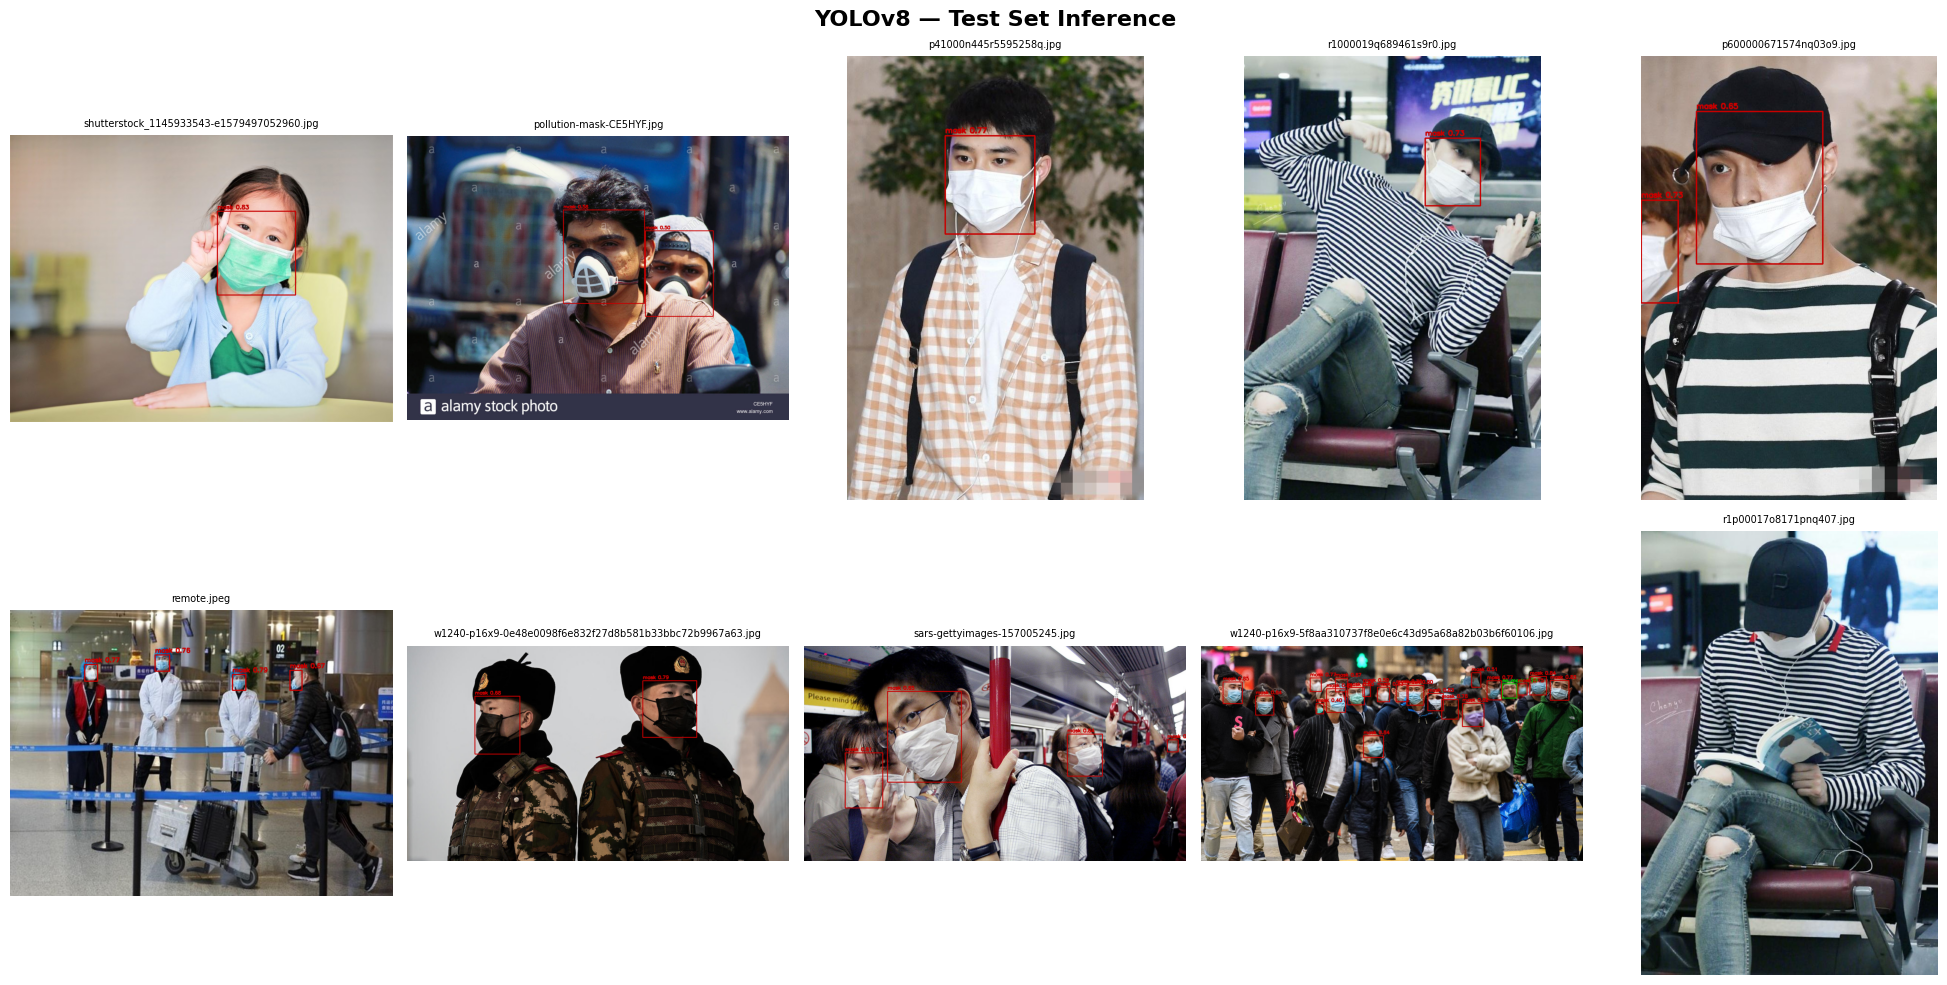

✅ Test inference done!


In [11]:
trained_model = YOLO(best_weights)

COLORS = {}
palette = [(0,200,0),(200,0,0),(200,130,0),(0,130,200),(130,0,200)]
for i, name in enumerate(class_names):
    COLORS[name] = palette[i % len(palette)]

test_imgs    = glob.glob(f'{LOCAL_DIR}/test/images/*.*')
if not test_imgs:
    test_imgs = glob.glob(f'{LOCAL_DIR}/valid/images/*.*')

sample_tests = random.sample(test_imgs, min(10, len(test_imgs)))
rows         = (len(sample_tests) + 4) // 5

fig, axes = plt.subplots(rows, 5, figsize=(20, 5*rows))
fig.suptitle('YOLOv8 — Test Set Inference', fontsize=16, fontweight='bold')
axes = axes.flatten() if rows > 1 else [axes] if len(sample_tests)==1 else list(axes)

for i, img_path in enumerate(sample_tests):
    result = trained_model.predict(img_path, conf=0.4, verbose=False)[0]
    img    = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    for box in result.boxes:
        x1,y1,x2,y2 = map(int, box.xyxy[0])
        cls_id       = int(box.cls[0])
        conf         = float(box.conf[0])
        name         = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
        color        = COLORS.get(name, (100,100,255))
        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        cv2.putText(img, f"{name} {conf:.2f}", (x1, y1-6),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(os.path.basename(img_path), fontsize=7)

for j in range(len(sample_tests), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
print("✅ Test inference done!")

In [12]:
import shutil

out_dir = '/content/drive/MyDrive/Yolo-Model-Face-Mask/trained_model'
os.makedirs(out_dir, exist_ok=True)

shutil.copy(best_weights, f'{out_dir}/best.pt')
shutil.copy(yaml_path,    f'{out_dir}/face_mask_data.yaml')

print(f"✅ Model saved to Drive: {out_dir}/best.pt")

✅ Model saved to Drive: /content/drive/MyDrive/Yolo-Model-Face-Mask/trained_model/best.pt


In [36]:
# ── LIVE WEBCAM INFERENCE WITH YOLOv8 IN GOOGLE COLAB ──────────────────────
# How it works:
#   1. JavaScript opens your webcam in the browser
#   2. Captures frames and sends them to Python via Colab's js-to-python bridge
#   3. YOLOv8 runs inference on each frame
#   4. Annotated frame is sent back and displayed in the browser

from IPython.display import display, Javascript, Image as IPyImage
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
import cv2
from ultralytics import YOLO
import os, glob

# ── Load trained model ───────────────────────────────────────────────────────
run_dirs     = sorted(glob.glob('/content/runs/face_mask*'))
run_dir      = run_dirs[-1]
best_weights = os.path.join(run_dir, 'weights', 'best.pt')

cam_model    = YOLO(best_weights)
print(f"✅ Model loaded: {best_weights}")
print(f"   Classes: {class_names}")

# ── Color map ────────────────────────────────────────────────────────────────
COLORS = {}
palette = [(0,220,0),(0,0,220),(0,140,220),(220,100,0),(180,0,180)]
for i, name in enumerate(class_names):
    COLORS[name] = palette[i % len(palette)]

# ── JavaScript: opens webcam and streams frames ──────────────────────────────
JS_CODE = """
async function startWebcam() {

  // ── Create UI ──────────────────────────────────────────────────────────
  const panel = document.createElement('div');
  panel.id    = 'webcam-panel';
  panel.style.cssText = `
    font-family: Arial, sans-serif;
    background: #1a1a2e; color: white;
    padding: 16px; border-radius: 12px;
    max-width: 720px; margin: 10px auto;
  `;

  panel.innerHTML = `
    <h3 style="margin:0 0 12px; color:#00d4ff;">
      😷 Face Mask Detection — Live Webcam
    </h3>
    <div style="display:flex; gap:12px; flex-wrap:wrap;">
      <div>
        <p style="margin:4px 0; font-size:12px; color:#aaa;">📷 Camera Feed</p>
        <video id="webcam-video" width="320" height="240"
               autoplay muted playsinline
               style="border-radius:8px; border:2px solid #333;"></video>
      </div>
      <div>
        <p style="margin:4px 0; font-size:12px; color:#aaa;">🎯 Detection Output</p>
        <img id="output-img" width="320" height="240"
             style="border-radius:8px; border:2px solid #00d4ff;
                    background:#000;"
             src="data:image/gif;base64,R0lGODlhAQABAAAAACH5BAEKAAEALAAAAAABAAEAAAICTAEAOw=="/>
      </div>
    </div>
    <div id="stats-bar" style="
      margin-top:10px; padding:8px 12px;
      background:#16213e; border-radius:8px;
      font-size:13px; color:#ccc;
    ">
      ⏳ Initializing camera...
    </div>
    <div style="margin-top:10px; display:flex; gap:8px;">
      <button id="btn-stop" style="
        padding:8px 20px; background:#e74c3c; color:white;
        border:none; border-radius:6px; cursor:pointer; font-size:14px;
      ">⏹ Stop</button>
      <span id="fps-counter" style="
        padding:8px 12px; background:#0f3460;
        border-radius:6px; font-size:13px;
      ">FPS: --</span>
    </div>
  `;
  document.querySelector('#output-area').appendChild(panel);

  // ── Start webcam ────────────────────────────────────────────────────────
  const video  = document.getElementById('webcam-video');
  const outImg = document.getElementById('output-img');
  const stats  = document.getElementById('stats-bar');
  const fpsEl  = document.getElementById('fps-counter');
  const canvas = document.createElement('canvas');
  canvas.width  = 320;
  canvas.height = 240;
  const ctx     = canvas.getContext('2d');

  let stream, running = true, frameCount = 0, lastFpsTime = Date.now();

  try {
    stream = await navigator.mediaDevices.getUserMedia({
      video: { width: 320, height: 240, facingMode: 'user' }, audio: false
    });
    video.srcObject = stream;
    await video.play();
    stats.innerHTML = '✅ Camera active — sending frames to YOLOv8...';
  } catch(e) {
    stats.innerHTML = '❌ Camera error: ' + e.message;
    return;
  }

  // ── Stop button ─────────────────────────────────────────────────────────
  document.getElementById('btn-stop').onclick = () => {
    running = false;
    if (stream) stream.getTracks().forEach(t => t.stop());
    video.srcObject = null;
    stats.innerHTML = '⏹ Stopped.';
  };

  // ── Frame loop ───────────────────────────────────────────────────────────
  while (running) {
    await new Promise(r => setTimeout(r, 80));   // ~12 fps capture rate
    if (!running) break;

    ctx.drawImage(video, 0, 0, 320, 240);
    const frameB64 = canvas.toDataURL('image/jpeg', 0.8).split(',')[1];

    try {
      // Send frame to Python and get annotated frame back
      const result = await google.colab.kernel.invokeFunction(
        'notebook.process_frame', [frameB64], {}
      );
      const annotated = result.data['application/json'];
      if (annotated && annotated.img) {
        outImg.src = 'data:image/jpeg;base64,' + annotated.img;
        stats.innerHTML   = annotated.info  || '';
      }
    } catch(e) {
      // silently continue on frame error
    }

    // FPS counter
    frameCount++;
    const now  = Date.now();
    const diff = (now - lastFpsTime) / 1000;
    if (diff >= 1.0) {
      fpsEl.textContent = `FPS: ${(frameCount / diff).toFixed(1)}`;
      frameCount   = 0;
      lastFpsTime  = now;
    }
  }
}

// Anchor div for the panel
const anchor = document.createElement('div');
anchor.id = 'output-area';
document.body.appendChild(anchor);

startWebcam();
"""

# ── Python callback: receives a frame, runs YOLOv8, returns annotated frame ─
import json
from google.colab import output as colab_output

def process_frame(frame_b64):
    try:
        # Decode JPEG frame
        img_bytes = b64decode(frame_b64)
        np_arr    = np.frombuffer(img_bytes, dtype=np.uint8)
        frame     = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)

        if frame is None:
            return json.dumps({'img': '', 'info': '❌ Bad frame'})

        # ── YOLOv8 inference ────────────────────────────────────────────────
        results   = cam_model.predict(frame, conf=0.45, verbose=False, imgsz=320)[0]

        # ── Draw detections ─────────────────────────────────────────────────
        counts    = {n: 0 for n in class_names}

        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls_id          = int(box.cls[0])
            conf            = float(box.conf[0])
            name            = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
            color           = COLORS.get(name, (200, 200, 200))
            counts[name]    = counts.get(name, 0) + 1

            # Box
            cv2.rectangle(frame, (x1,y1), (x2,y2), color, 2)

            # Label background
            label     = f"{name} {conf:.2f}"
            (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(frame, (x1, y1-th-8), (x1+tw+4, y1), color, -1)
            cv2.putText(frame, label, (x1+2, y1-4),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

        # ── Stats overlay (top-left) ─────────────────────────────────────────
        overlay = frame.copy()
        cv2.rectangle(overlay, (0,0), (230, 28 + 22*len(class_names)), (20,20,40), -1)
        frame   = cv2.addWeighted(overlay, 0.6, frame, 0.4, 0)
        cv2.putText(frame, "YOLOv8 Detection", (8, 18),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,210,255), 1)
        for i, (cname, cnt) in enumerate(counts.items()):
            color = COLORS.get(cname, (200,200,200))
            cv2.putText(frame, f"  {cname}: {cnt}", (8, 38 + i*22),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.48, color, 1)

        # ── Encode annotated frame ───────────────────────────────────────────
        _, buf   = cv2.imencode('.jpg', frame, [cv2.IMWRITE_JPEG_QUALITY, 85])
        out_b64  = b64encode(buf).decode('utf-8')

        # Info string for the stats bar
        parts    = [f"<span style='color:#0f0'>{k}: {v}</span>" if k == class_names[0]
                    else f"<span style='color:#f44'>{k}: {v}</span>"
                    for k, v in counts.items()]
        info_str = "🎯 Detections — " + " | ".join(parts)

        return json.dumps({'img': out_b64, 'info': info_str})

    except Exception as e:
        return json.dumps({'img': '', 'info': f'⚠️ Error: {str(e)}'})

# Register Python callback so JS can call it
colab_output.register_callback('notebook.process_frame', process_frame)

# Launch the webcam UI
print("📷 Starting live webcam detection...")
print("   Allow camera access when your browser asks.")
print("   Click ⏹ Stop when done.\n")
display(Javascript(JS_CODE))

✅ Model loaded: /content/runs/face_mask/weights/best.pt
   Classes: ['no_mask', 'mask']
📷 Starting live webcam detection...
   Allow camera access when your browser asks.
   Click ⏹ Stop when done.



<IPython.core.display.Javascript object>

📸 Capturing frame from webcam...
  → mask: 70.18%


/tmp/ipython-input-3261520273.py:55: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


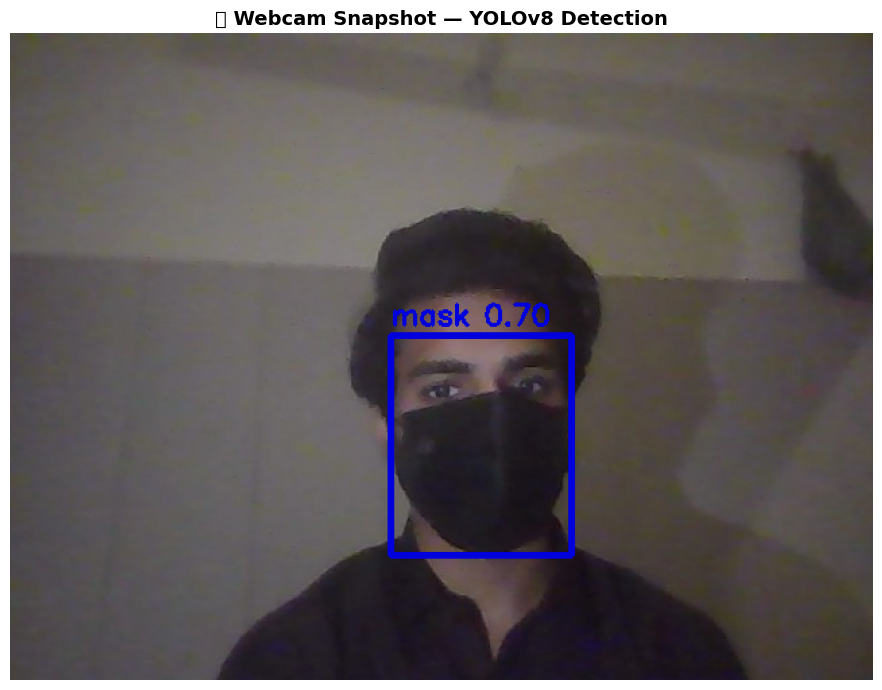

In [38]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2, numpy as np
import matplotlib.pyplot as plt

# Capture one frame from webcam
JS_SNAP = """
async function captureFrame() {
  const video  = document.createElement('video');
  const canvas = document.createElement('canvas');
  const stream = await navigator.mediaDevices.getUserMedia({video:true, audio:false});
  video.srcObject = stream;
  await video.play();
  await new Promise(r => setTimeout(r, 1500));  // warm-up
  canvas.width  = video.videoWidth;
  canvas.height = video.videoHeight;
  canvas.getContext('2d').drawImage(video, 0, 0);
  stream.getTracks().forEach(t => t.stop());
  return canvas.toDataURL('image/jpeg', 0.9);
}
captureFrame();
"""

print("📸 Capturing frame from webcam...")
frame_data = eval_js(JS_SNAP)
img_bytes  = b64decode(frame_data.split(',')[1])
np_arr     = np.frombuffer(img_bytes, np.uint8)
frame      = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)

# Run inference
snap_model = YOLO(best_weights)
result     = snap_model.predict(frame, conf=0.4, verbose=False)[0]

# Draw boxes
img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
for box in result.boxes:
    x1,y1,x2,y2 = map(int, box.xyxy[0])
    cls_id       = int(box.cls[0])
    conf         = float(box.conf[0])
    name         = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
    color        = COLORS.get(name, (100,100,255))
    cv2.rectangle(img_rgb, (x1,y1), (x2,y2), color, 3)
    cv2.putText(img_rgb, f"{name} {conf:.2f}", (x1, y1-8),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    print(f"  → {name}: {conf:.2%}")

if not result.boxes:
    print("  No detections above threshold.")

plt.figure(figsize=(10, 7))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("📸 Webcam Snapshot — YOLOv8 Detection", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()